## Task 10.1.1: Training a CNN

First, we recommend using PyTorch for this assignment, a popular machine learning framework. Should be able to install it according to the official instructions on [pytorch.org](https://pytorch.org/).

It might be useful to use [Google Colab](https://colab.research.google.com), too. Google offers some compute, so you are not stuck running your programs locally. You can even use GPUs and TPUs! For this assignment, your local machine should be enough, though. In Google Colab variables might get lost when your computer disconnects from the internet or the notebook runs idle for a while.

Browse through the [pytorch tutorials ](https://pytorch.org/tutorials/), they often come as colab notebooks - go and execute some!

* Set up your own convolutionnal network of the following structure **(RESULT)**:
    * 3 convolution layers
    * 2 fully connected layers
* Use some padding, stride, pooling, drop out and batch normalization. You should use the ReLU activation function.  **(RESULT)**
* Initialize your model, build a train and test function and display the model's performance on the MNIST classification task. **(RESULT)**

In [1]:
# imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import sys
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Some hyperparameters that might be useful for the neural network
# (adapt them to your needs)

n_epochs = 5    # Total number of training iterations
batch_size_train = 128   # Number of training samples utilized per iteration
batch_size_test = 1000  # Number of test samples utilized per iteration
learning_rate = 0.01
momentum = 0.9  # Momentum for the optimizer (if applicable)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Prepare MNIST data
transform = transforms.Compose([

      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))

  ])


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)
# TODO

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [3]:
# Define our model class `CNN` which extends from `torch.nn.Module`.
class CNN(torch.nn.Module):
  def __init__(self, D_out,  D_in=28):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batchnorm1 = nn.BatchNorm2d(16)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(0.25)
    inputdimensionafterpool= int(((D_in/2)/2)/2)
    # print(inputdimensionafterpool)
    self.fc1= nn.Linear(in_features=64*inputdimensionafterpool*inputdimensionafterpool, out_features=128)
    self.fc2= nn.Linear(in_features=128, out_features=D_out)
    self.relu = nn.ReLU()


    # TODO: Define layers

  def forward(self, x):
    x=self.relu(self.conv1(x))
    x=self.batchnorm1(x)
    x=self.pool(x)
    x=self.relu(self.conv2(x))
    x=self.batchnorm2(x)
    x=self.pool(x)
    x=self.relu(self.conv3(x))
    x=self.batchnorm3(x)
    x=self.pool(x)
    x = torch.flatten(x, 1)
    x=self.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x





  def run_train(self, trainloader, device, epochs, criterion, optimizer, testloader):

    TrainLosses=[]
    TestLosses=[]
    TrainAccuracyperepoch=[]
    TestAccuracyperepoch=[]
    for i in range(epochs):
      totaltrainloss=0
      totaltestloss=0
      totalTrainAcc=0
      correctTrain=0
      correctTest=0
      totaltestAcc=0
      self.train()
      for batch_x, batch_y in trainloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = self(batch_x)
        loss = criterion(output, batch_y)
        totaltrainloss+=loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        correctTrain += (predicted == batch_y).sum().item()
        totalTrainAcc += batch_y.size(0)
      self.eval()
      with torch.no_grad():
        for batch_x, batch_y in testloader:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
          output = self(batch_x)
          loss = criterion(output, batch_y)
          totaltestloss+=loss.item()
          _, predicted = torch.max(output.data, 1)
          correctTest += (predicted == batch_y).sum().item()
          totaltestAcc += batch_y.size(0)
      TrainAccuracyperepoch.append(correctTrain/totalTrainAcc)
      TestAccuracyperepoch.append(correctTest/totaltestAcc)
      averagelossperepoch=totaltrainloss/len(trainloader)
      averagetestloss=totaltestloss/len(testloader)
      TestLosses.append(averagetestloss)
      TrainLosses.append(averagelossperepoch)
      print ("Epoch: ", i, "Average Training Loss: ", averagelossperepoch)
    return TrainLosses, TestLosses, TrainAccuracyperepoch, TestAccuracyperepoch

  def run_test(self, testloader, device):
    self.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for batch_x, batch_y in testloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        outputs = self(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    return correct / total


In [4]:
model = CNN(10)
model.to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Trainlosses, Testlosses, TrainAccuracyperepoch, TestAccuracyperepoch=model.run_train(trainloader, device, n_epochs, criterion, optimizer, testloader)
Accuracy=model.run_test(testloader, device)
print("Test Accuracy:  ", Accuracy)



Epoch:  0 Average Training Loss:  0.18520558562908154
Epoch:  1 Average Training Loss:  0.07593641514832308
Epoch:  2 Average Training Loss:  0.055175971908510715
Epoch:  3 Average Training Loss:  0.04657078472197926
Epoch:  4 Average Training Loss:  0.043990366632736394
Test Accuracy:   0.9889


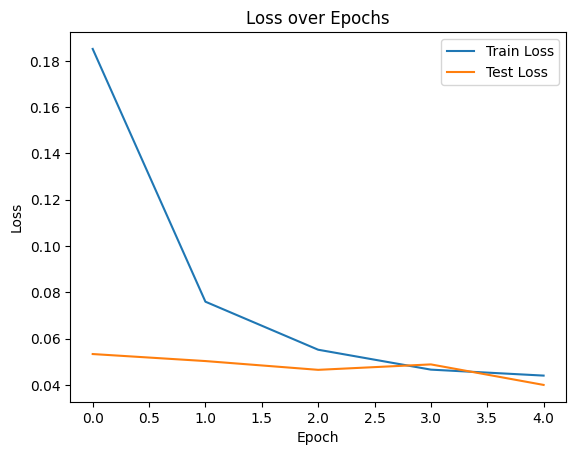

In [5]:
plt.figure()
plt.plot(Trainlosses, label="Train Loss")
plt.plot(Testlosses, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()


Text(0.5, 1.0, 'Accuracy over Epochs')

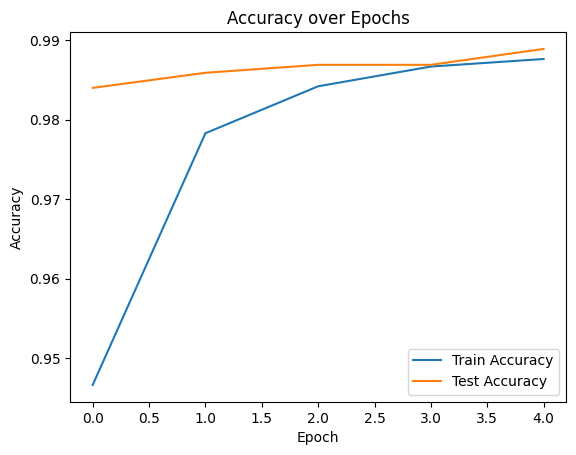

In [6]:
plt.figure()
plt.plot(TrainAccuracyperepoch, label="Train Accuracy")
plt.plot(TestAccuracyperepoch, label="Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")

## Task 10.1.2: Compare vs fully connected network

* Compare the performance of your CNN to a fully connected network of similar size (number of parameters). **(RESULT)**
* Plot training and test accuracy/loss curves for both models. Train each for 2 epochs. **(RESULT)**

CNN has 98666 parameters while FC has 97060 which is very similar

In [7]:
class SimpleFC(nn.Module):
    def __init__(self, input_dimension):
        super(SimpleFC, self).__init__()
        self.net= nn.Sequential(nn.Linear(input_dimension, 110), nn.ReLU(),  nn.Linear(110, 80),nn.ReLU(),  nn.Linear(80, 20), nn.ReLU(), nn.Linear(20, 10))


    def forward(self,x):
        return self.net(x)

    def run_train(self, trainloader, device, epochs, criterion, optimizer, testloader):

      trainlosses=[]
      testlosses=[]
      TrainAccuracyperepoch=[]
      TestAccuracyperepoch=[]
      for i in range(epochs):
        totaltrainloss=0
        totaltestloss=0
        totalTrainAcc=0
        correctTrain=0
        correctTest=0
        totaltestAcc=0
        self.train()
        for batch_x, batch_y in trainloader:
          batch_x = batch_x.view(batch_x.shape[0], -1).to(device)
          batch_y = batch_y.to(device)
          optimizer.zero_grad()
          output = self(batch_x)
          loss = criterion(output, batch_y)
          totaltrainloss+=loss.item()
          loss.backward()
          optimizer.step()
          _, predicted = torch.max(output.data, 1)
          correctTrain += (predicted == batch_y).sum().item()
          totalTrainAcc += batch_y.size(0)
        self.eval()
        with torch.no_grad():
          for batch_x, batch_y in testloader:
            batch_x = batch_x.view(batch_x.shape[0], -1).to(device)
            batch_y = batch_y.to(device)
            output = self(batch_x)
            loss = criterion(output, batch_y)
            totaltestloss+=loss.item()
            _, predicted = torch.max(output.data, 1)
            correctTest += (predicted == batch_y).sum().item()
            totaltestAcc += batch_y.size(0)
        TrainAccuracyperepoch.append(correctTrain/totalTrainAcc)
        TestAccuracyperepoch.append(correctTest/totaltestAcc)
        averagetrainloss=totaltrainloss/len(trainloader)
        averagetestloss=totaltestloss/len(testloader)
        trainlosses.append(averagetrainloss)
        testlosses.append(averagetestloss)
        print ("Epoch: ", i, "Average Training Loss: ", averagetrainloss)
      return trainlosses, testlosses, TrainAccuracyperepoch, TestAccuracyperepoch
    def run_test(self, testloader, device):
      self.eval()
      correct = 0
      total = 0
      with torch.no_grad():
        for batch_x, batch_y in testloader:
          batch_x = batch_x.view(batch_x.shape[0], -1).to(device)
          batch_y = batch_y.to(device)
          outputs = self(batch_x)
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == batch_y).sum().item()
          total += batch_y.size(0)
      return correct / total




# Train and test CNN

In [8]:
model = CNN(10)
model.to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

CNNTrainlosses, CNNTestlosses, CNNTrainAccuracyperepoch, CNNTestAccuracyperepoch=model.run_train(trainloader, device, 2, criterion, optimizer, testloader)
print("Test Accuracy:  ", model.run_test(testloader, device))



Epoch:  0 Average Training Loss:  0.16440933056350457
Epoch:  1 Average Training Loss:  0.06946423347505219
Test Accuracy:   0.9896


# Train and test FC network

In [9]:
fc= SimpleFC(28*28)
fc.to(device)
FCTrainlosses, FCTestlosses, FCTrainAccuracyperepoch, FCTestAccuracyperepoch=fc.run_train(trainloader, device, 2, criterion, optimizer, testloader)
print("Test Accuracy: ", fc.run_test(testloader, device))

Epoch:  0 Average Training Loss:  2.3162802856868265
Epoch:  1 Average Training Loss:  2.3162761100573834
Test Accuracy:  0.0997


# Comparison

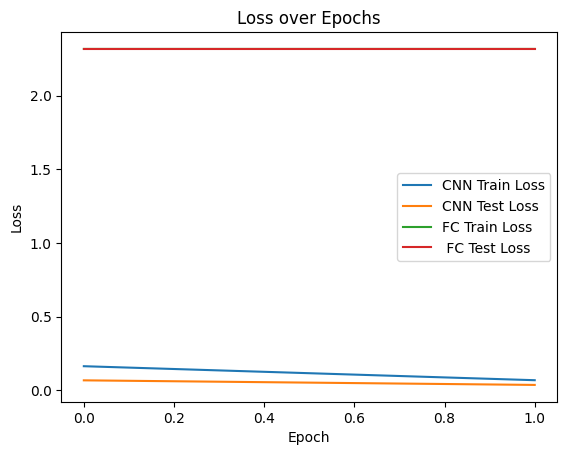

In [10]:
plt.figure()
plt.plot(CNNTrainlosses, label="CNN Train Loss")
plt.plot(CNNTestlosses, label="CNN Test Loss")
plt.plot(FCTrainlosses, label="FC Train Loss")
plt.plot(FCTestlosses, label=" FC Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()

Text(0.5, 1.0, 'Accuracy over Epochs')

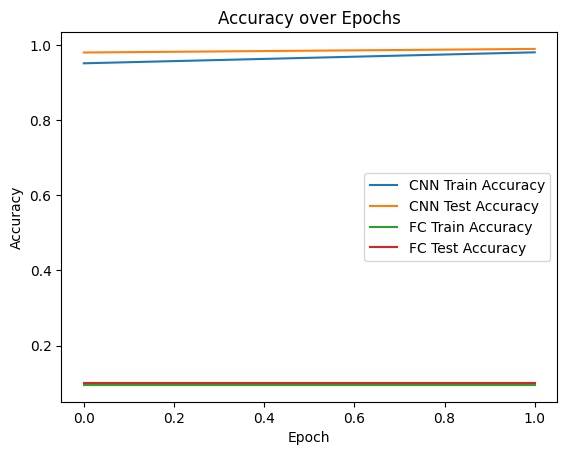

In [11]:
plt.figure()

plt.plot(CNNTrainAccuracyperepoch, label="CNN Train Accuracy")
plt.plot(CNNTestAccuracyperepoch, label="CNN Test Accuracy")
plt.plot(FCTrainAccuracyperepoch, label="FC Train Accuracy")
plt.plot(FCTestAccuracyperepoch, label="FC Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")

As expected a fully connected network performs much poorly compared to a CNN of similar number of paramters.

## Congratz, you made it! :)